# Multi-time series forecaster

Univariate time series forecasters, such as `ForecasterAutoreg`, create models that learn from the lags of a single time series and use this information to make predictions. But, in some cases, there may be 2 or more time series that can depend or not on each other. Two use cases can be distinguished:

- **Multiple time series**: The data are composed of multiple univariate time series that are not directly dependent on each other but have the same intrinsic relationship. For example, sales of different products in a food store. The sales of products A and B may not be related but they follow the same dynamics, that of the store. 


- **Multivariate time series**: Each time series not only depends on its past values but also has some dependence on other variables, i.e., past information from one provides information to the other and vice versa. The forecaster is expected not only to learn the information of each series separately but also to relate them. For example, the measurements taken by all the sensors (flow, temperature, pressure...) installed on an industrial machine such as a compressor.

The `ForecasterAutoregMultiSeries` class covers the use case of **multiple time series**.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4;">

<p class="title">
    <i class="fa-circle-exclamation fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>
    
<code>ForecasterAutoregMultivariate</code> will be released in a future version of <b>Skforecast</b> - stay tuned!

</div>

The `ForecasterAutoregMultiSeries` **training matrix** is created as shown in the following figure.

<p align="center"><img src="../img/forecaster_multi_series_create_train_matrix_diagram.png" style="width: 800px"></p>

`ForecasterAutoregMultiSeries` shares methods with other forecasters, so to predict the next *n* steps either method `predict()` or `predict_interval()` can be used. The only aspect to take into account is the `level` argument. This indicates on which of the series used to train the forecaster the prediction is to be made.

<p align="center"><img src="../img/forecaster_multi_series_prediction_diagram.png" style="width: 800px"></p>

## Libraries

In [33]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries

## Data

In [20]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
data = pd.read_csv(url, sep=',')

# Data preparation (aggregation at daily level)
# ==============================================================================
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right')\
       .agg({'Demand': 'sum', 'Temperature': 'mean', 'Holiday': 'max'})

data.head()

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,8646.190700,21.225,True
2011-12-31 15:00:00,7926.529376,20.625,True
2011-12-31 16:00:00,7901.826990,20.325,True
2011-12-31 17:00:00,7255.721350,19.850,True
2011-12-31 18:00:00,6792.503352,19.025,True


In [21]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2014-06-01 00:00:00': '2014-07-31 23:59:00']
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2014-06-01 00:00:00 --- 2014-07-15 23:00:00  (n=1080)
Test dates       : 2014-07-16 00:00:00 --- 2014-07-31 23:00:00  (n=384)


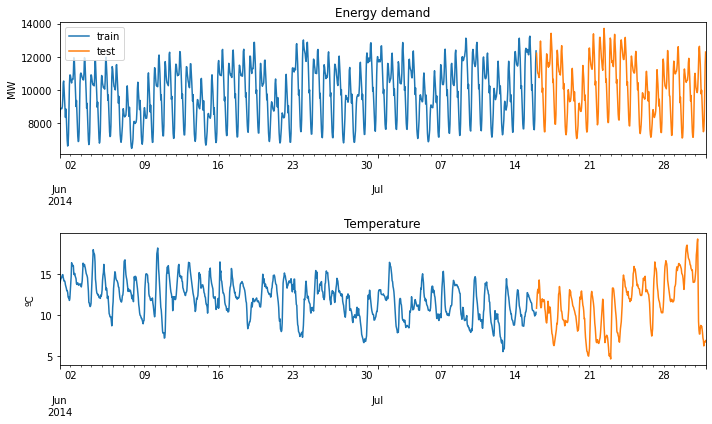

In [24]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

data_train['Demand'].plot(label='train', ax=axes[0])
data_test['Demand'].plot(label='test', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

data_train['Temperature'].plot(label='train', ax=axes[1])
data_test['Temperature'].plot(label='test', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show();

## Train and Predict ForecasterAutoregMultiSeries

In [30]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LinearRegression(),
                 lags = 24,
                 transformer_series = None,
                 transformer_exog = None
             )

forecaster.fit(series=data_train[['Demand', 'Temperature']])
forecaster

ForecasterAutoregMultiSeries 
Regressor: LinearRegression() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for series: {'Demand': None, 'Temperature': None} 
Transformer for exog: None 
Window size: 24 
Series levels: ['Demand', 'Temperature'] 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-06-01 00:00:00'), Timestamp('2014-07-15 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False} 
Creation date: 2022-09-20 11:59:14 
Last fit date: 2022-09-20 11:59:14 
Skforecast version: 0.5.0 
Python version: 3.8.13 

In [31]:
# Predict and predict_interval
# ==============================================================================
steps = 24

# Predictions for Demand
predictions_demand = forecaster.predict(steps=steps, level='Demand')
display(predictions_demand.head(3))

# Interval predictions for Temperature
predictions_temp = forecaster.predict_interval(steps=steps, level='Temperature')
display(predictions_temp.head(3))

2014-07-16 00:00:00    12650.090315
2014-07-16 01:00:00    12481.753017
2014-07-16 02:00:00    12106.341026
Freq: H, Name: pred, dtype: float64

,pred,lower_bound,upper_bound
2014-07-16 00:00:00,10.731159,9.759160,11.701027
2014-07-16 01:00:00,11.267491,9.373177,13.086183
2014-07-16 02:00:00,12.057060,9.589110,14.421818


## Backtesting Multi Series

As in the `predict` method, the `level` at which [backtesting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html) is performed must be indicated.

In [35]:
# Backtesting Multi Series
# ==============================================================================
metric, predictions_demand = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Demand',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Demand: {metric}")
display(predictions_demand.head(4))

metric, predictions_temp = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Temperature',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = [mean_absolute_error, 'mean_squared_error'],
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Temperature: {metric}")
display(predictions_temp.head(4))

Backtest error Demand: 571.2243117377348


,pred
2014-07-16 00:00:00,12650.090315
2014-07-16 01:00:00,12481.753017
2014-07-16 02:00:00,12106.341026
2014-07-16 03:00:00,12022.826511


Backtest error Temperature: [1.749642786356965, 5.661807796665971]


,pred
2014-07-16 00:00:00,10.731159
2014-07-16 01:00:00,11.267491
2014-07-16 02:00:00,12.057060
2014-07-16 03:00:00,12.721039


## Hyperparameter tuning and lags selection Multi Series

The `model_selection_multiseries` module has available the `grid_search_forecaster_multiseries` and `random_search_forecaster_multiseries` functions for lag and hyperparameter optimization in `ForecasterAutoregMultiSeries`. The optimization is performed in the same way as in the other forecasters, [see the user_guide here](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/hyperparameter-tuning-and-lags-selection.html), except for 2 arguments `levels_list` and `levels_weights`. 

`levels_list` refers to which level or levels the forecaster is optimized. In this use case:

- If `level_list = ['Demand', 'Temperature']` (Same as `level_list = None`), the function will search for the lags and hyperparameters that minimize the error of the predictions of both time series. The resulting metric will be a weighted average of the optimization of both levels.


- If `level_list = 'Demand'` (Same as `level_list = ['Demand']`), the function will search for the lags and hyperparameters that minimize the error of the `Demand` predictions.

`levels_weights` refers to the weights associated with the levels in the optimization. 

- If `level_list = ['Demand', 'Temperature']` and `levels_weights = {'Demand': 0.5, 'Temperature': 0.5}` (Same as `levels_weights = None`), both time series will have the same weight in the calculation of the resulting metric.

The following example shows how to use `grid_search_forecaster_multiseries` to optimize the prediction of both time series with the same weight distribution:

In [ ]:
# Create and fit forecaster multi series
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = Ridge(random_state=123),
                 lags = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog = None
             )

forecaster.fit(series = data_train[['Demand', 'Temperature']])

In [ ]:
# Grid search Multi Series
# ==============================================================================
lags_grid = [24, 48]
param_grid = {'alpha': [0.01, 0.1, 1]}

levels_list = ['Demand', 'Temperature'] # Both time series
levels_weights = {'Demand': 0.5, 'Temperature': 0.5} # Same weight distribution

results = grid_search_forecaster_multiseries(
                forecaster          = forecaster,
                series              = data[['Demand', 'Temperature']],
                lags_grid           = lags_grid,
                param_grid          = param_grid,
                steps               = 24,
                metric              = 'mean_absolute_error',
                initial_train_size  = len(data_train),
                fixed_train_size    = True,
                levels_list         = levels_list,
                levels_weights      = levels_weights,
                exog                = None,
                refit               = True,
                return_best         = False,
                verbose             = False
          )

results

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100;">

<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b> &nbsp Warning</b>
</p>

Use <b>multiple metrics</b> in the hyperparameter tuning and <code>bayesian_search_forecaster_multiseries</code> will be released in a future version of <b>Skforecast</b>
    
Stay tuned!

</div>

## ForecasterAutoregMultiSeries with linear models

Backtest error Demand: 571.4134663574489


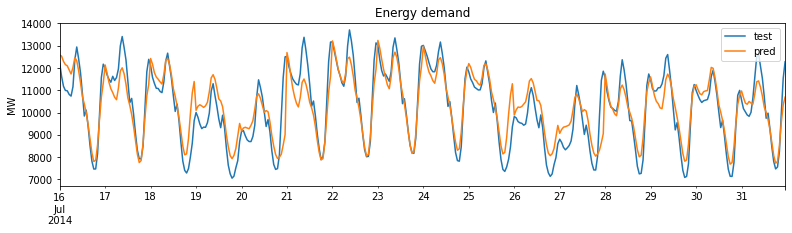

,feature,importance
0,lag_1,1.472824
1,lag_2,-0.622111
2,lag_3,0.116596
3,lag_4,-0.142653
4,lag_5,0.042039
5,lag_6,0.196985
6,lag_7,-0.184840
7,lag_8,-0.048217
8,lag_9,0.090637
9,lag_10,0.085398


In [71]:
# ForecasterAutoregMultiSeries with linear models
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LinearRegression(),
                 lags = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog = None
             )

# Backtesting
# ==============================================================================
metric, predictions_demand = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Demand',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Demand: {metric}")

# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 3))
data_test['Demand'].plot(label='test', ax=ax)
predictions_demand.plot(label='pred', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('MW')
ax.set_title('Energy demand')
ax.legend()
plt.show();

forecaster.fit(series=data[['Demand', 'Temperature']])
forecaster.get_feature_importance()

Train dates : 2014-06-01 00:00:00 --- 2014-07-15 23:00:00  (n=1080)
Test dates  : 2014-07-16 00:00:00 --- 2014-07-31 23:00:00  (n=384)


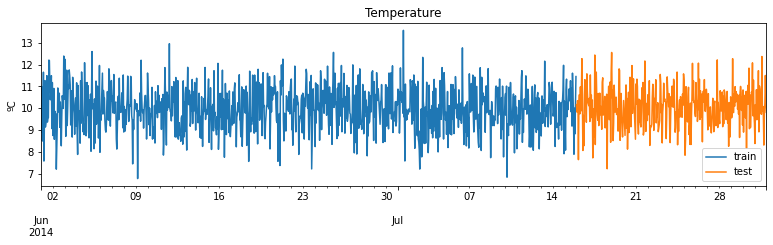

In [72]:
# Copy data and modify Temperature column as a normal distribution
# ==============================================================================
np.random.seed(123)
data_altered = data.copy()
data_altered['Temperature'] = np.random.normal(size=len(data_altered), loc=10, scale=1)

# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_train_altered = data_altered.loc[:end_train, :].copy()
data_test_altered  = data_altered.loc[end_train:, :].copy()

print(f"Train dates : {data_train_altered.index.min()} --- {data_train_altered.index.max()}  (n={len(data_train_altered)})")
print(f"Test dates  : {data_test_altered.index.min()} --- {data_test_altered.index.max()}  (n={len(data_test_altered)})")

# Plot Temperature
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 3))
data_train_altered['Temperature'].plot(label='train', ax=ax)
data_test_altered['Temperature'].plot(label='test', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('ºC')
ax.set_title('Temperature')
ax.legend()
plt.show();

Backtest error Demand: 793.286743410266


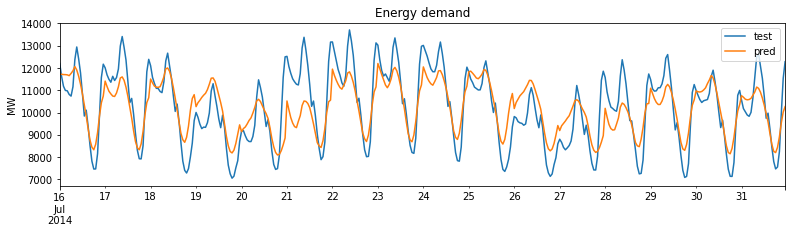

,feature,importance
0,lag_1,2.651592e-01
1,lag_2,1.329005e-01
2,lag_3,4.087505e-02
3,lag_4,5.340369e-03
4,lag_5,1.409730e-02
5,lag_6,-4.711637e-02
6,lag_7,1.941936e-02
7,lag_8,-2.251437e-02
8,lag_9,-4.662772e-03
9,lag_10,2.888394e-02


In [73]:
# ForecasterAutoregMultiSeries with linear models
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = LinearRegression(),
                 lags = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog = None
             )

# Backtesting
# ==============================================================================
metric, predictions_demand = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data_altered[['Demand', 'Temperature']],
                                        level      = 'Demand',
                                        initial_train_size = len(data_train_altered),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Demand: {metric}")

# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 3))
data_test['Demand'].plot(label='test', ax=ax)
predictions_demand.plot(label='pred', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('MW')
ax.set_title('Energy demand')
ax.legend()
plt.show();

forecaster.fit(series=data_altered[['Demand', 'Temperature']])
forecaster.get_feature_importance()

## ForecasterAutoregMultiSeries with nonlinear models

In [ ]:
# ForecasterAutoregMultiSeries with nonlinear models
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = RandomForestRegressor(random_state=123),
                 lags = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog = None
             )

# Backtesting
# ==============================================================================
metric, predictions_demand = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data[['Demand', 'Temperature']],
                                        level      = 'Demand',
                                        initial_train_size = len(data_train),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Demand: {metric}")

# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 3))
data_test['Demand'].plot(label='test', ax=ax)
predictions_demand.plot(label='pred', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('MW')
ax.set_title('Energy demand')
ax.legend()
plt.show();

forecaster.fit(series=data[['Demand', 'Temperature']])
forecaster.get_feature_importance()

In [ ]:
# Copy data and modify Temperature column as a normal distribution
# ==============================================================================
np.random.seed(123)
data_altered = data.copy()
data_altered['Temperature'] = np.random.normal(size=len(data_altered), loc=10, scale=1)

# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_train_altered = data_altered.loc[:end_train, :].copy()
data_test_altered  = data_altered.loc[end_train:, :].copy()

print(f"Train dates : {data_train_altered.index.min()} --- {data_train_altered.index.max()}  (n={len(data_train_altered)})")
print(f"Test dates  : {data_test_altered.index.min()} --- {data_test_altered.index.max()}  (n={len(data_test_altered)})")

# Plot Temperature
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 3))
data_train_altered['Temperature'].plot(label='train', ax=ax)
data_test_altered['Temperature'].plot(label='test', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('ºC')
ax.set_title('Temperature')
ax.legend()
plt.show();

In [ ]:
# ForecasterAutoregMultiSeries with nonlinear models
# ==============================================================================
forecaster = ForecasterAutoregMultiSeries(
                 regressor = RandomForestRegressor(random_state=123),
                 lags = 24,
                 transformer_series = StandardScaler(),
                 transformer_exog = None
             )

# Backtesting
# ==============================================================================
metric, predictions_demand = backtesting_forecaster_multiseries(
                                        forecaster = forecaster,
                                        series     = data_altered[['Demand', 'Temperature']],
                                        level      = 'Demand',
                                        initial_train_size = len(data_train_altered),
                                        fixed_train_size   = True,
                                        steps      = 24,
                                        metric     = 'mean_absolute_error',
                                        refit      = True,
                                        verbose    = False
                                  )

print(f"Backtest error Demand: {metric}")

# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(13, 3))
data_test['Demand'].plot(label='test', ax=ax)
predictions_demand.plot(label='pred', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('MW')
ax.set_title('Energy demand')
ax.legend()
plt.show();

forecaster.fit(series=data_altered[['Demand', 'Temperature']])
forecaster.get_feature_importance()

In [18]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>